## Содержание

## Библиотеки

In [1]:
import os
from time import strftime

import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss, TripletMarginLoss
from torch.utils.tensorboard import SummaryWriter

import dataset.custom_datasets as cust_ds
import dataset.default_augmentations as def_augs
import dataset.classif_dataset_test as cl_ds_test
import dataset.tl_dataset_test as tl_ds_test

from models.triplet_loss import TripletLossModel, ClassificationForTLModel
import model_test.classify_model_test as class_m_test
import model_test.tl_model_test as tl_m_test
from model_selection.metrics import CustomAccuracy, F1Score
from model_selection.metrics import CustomVarianceCriteria

import tools.tl_base_callback as tl_call
from tools.vectorizer import Vectorizer

In [2]:
datasets_path = 'G:\\diplom\\project\\triplet_loss_project_2_06.04\\data'
train_ds_path = os.path.join(datasets_path, 'sampled_train_marks_models')
test_ds_path = os.path.join(datasets_path, 'sampled_test')

In [3]:
def marks_indx_f(x):
    return (x[0],)


def models_indx_f(x):
    return (x[0], x[1])

## 1. Модель классификации

**Тест датасета**

In [4]:
classif_ds_train = cust_ds.TLClassifyDataset(
    train_ds_path, marks_indx_f, crop=False,
    transform=def_augs.clTL_train_augs_128
)

classif_ds_test = cust_ds.TLClassifyDataset(
    test_ds_path, marks_indx_f, crop=False,
    transform=def_augs.clTL_test_augs_128
)

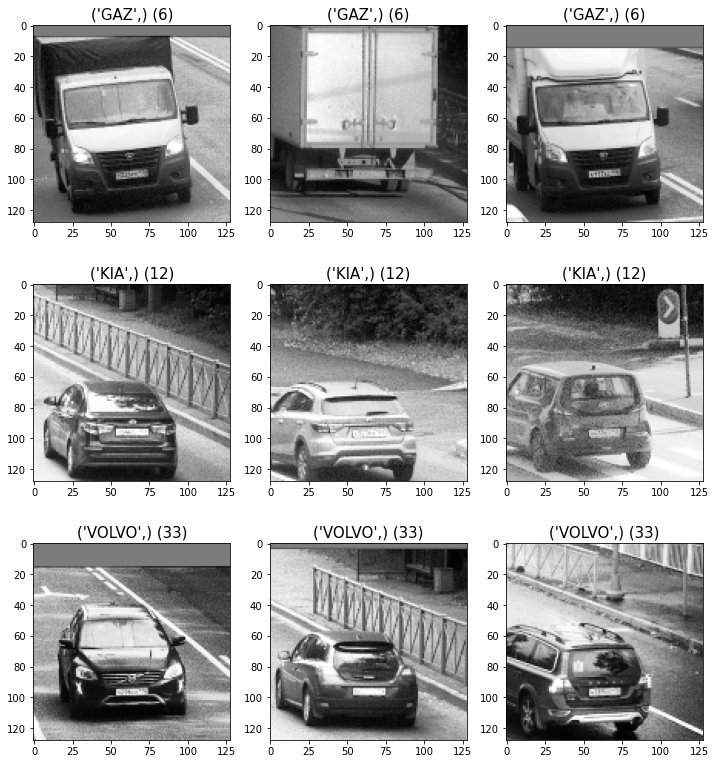

In [5]:
cl_ds_test.classify_ds_test(classif_ds_test, n_rows=3,
                            lines_span=1.5, figsize_sq=3)

**Тест модели**

In [6]:
mark_classes_n = len(classif_ds_train.labels_code)
class_mark_model = ClassificationForTLModel(mark_classes_n)

Визуальный:

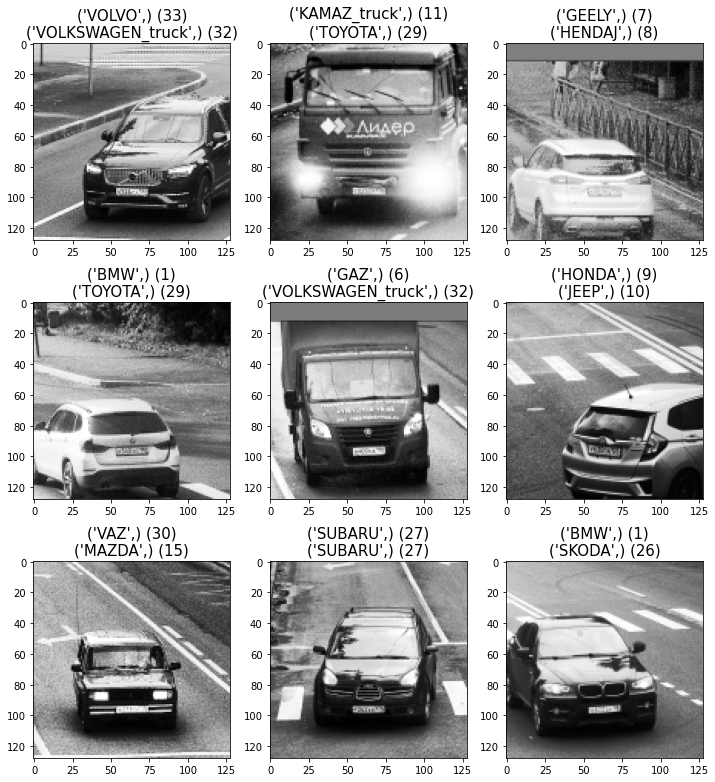

In [7]:
n_rows = 3

t = class_m_test.test_classif_model(class_mark_model,
                                    classif_ds_test,
                                    n_rows=n_rows)

cl_ds_test.classify_ds_test(classif_ds_test, n_rows=n_rows,
                            lines_span=1.5, figsize_sq=3,
                            imgs_indexes=t[0], add_to_title=t[1])

Accuracy

In [8]:
acc = CustomAccuracy()

In [9]:
acc_bef_learn = acc.ds_scope(classif_ds_test, class_mark_model)

  0%|          | 0/167 [00:00<?, ?it/s]

In [10]:
print(f'Accuracy модели до обучения: {round(acc_bef_learn, 3)}')

Accuracy модели до обучения: 0.041


f1 score

In [11]:
f1_score = F1Score()

In [12]:
f1_score_bef_learn = f1_score.ds_scope(classif_ds_test, class_mark_model)

  0%|          | 0/167 [00:00<?, ?it/s]

In [13]:
print(f'f1 score модели до обучения: {round(f1_score_bef_learn, 3)}')

f1 score модели до обучения: 0.003


**Обучение модели**

In [14]:
criterion = CrossEntropyLoss()
optimizer = Adam(class_mark_model.parameters(), lr=0.0001,
                 betas=(0.9, 0.999), eps=1e-08,
                 weight_decay=0, amsgrad=False)

class_mark_model.compile_settings(criterion, optimizer)

C:\Users\ski6a\anaconda3\envs\cv_env\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [15]:
s='''
current_time = strftime('%d-%m_%H-%M-%S')
logdir = f'runs2/{current_time}'
os.makedirs(logdir)
writer = SummaryWriter(log_dir=logdir)

loss_function = CrossEntropyLoss()
delimeter=20
w_filepaths = ['weights/1. classify for triplet loss/conv2Dfeatures.pt',
               'weights/1. classify for triplet loss/fully_connect.pt']

callback = tl_call.ClassifyCallBack(writer, classif_ds_test,
                                    loss_function, delimeter,
                                    w_filepaths)
'''

In [16]:
w_filepaths_load = [
    'weights/1. classify for triplet loss - marks/900 epochs/conv2Dfeatures.pt',
    'weights/1. classify for triplet loss - marks/900 epochs/fully_connect.pt'
]

class_mark_model.split_load(w_filepaths_load)

In [17]:
epochs = 10000
# class_mark_model.fit(classif_ds_train, epochs, callback=callback)

In [18]:
acc_aft_learn = acc.ds_scope(classif_ds_test, class_mark_model)
print(f'Accuracy модели после обучения: {round(acc_aft_learn, 3)}')

  0%|          | 0/167 [00:00<?, ?it/s]

Accuracy модели после обучения: 0.569


In [19]:
f1_score_aft_learn = f1_score.ds_scope(classif_ds_test, class_mark_model)
print(f'f1 score модели после обучения: {round(f1_score_aft_learn, 3)}')

  0%|          | 0/167 [00:00<?, ?it/s]

f1 score модели после обучения: 0.474


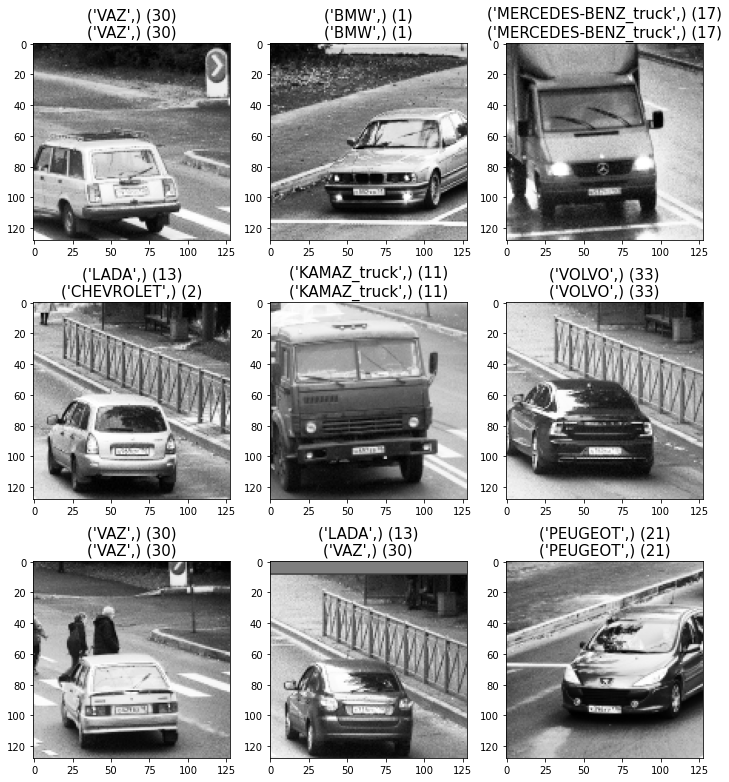

In [20]:
n_rows = 3

t = class_m_test.test_classif_model(class_mark_model,
                                    classif_ds_test,
                                    n_rows=n_rows)

cl_ds_test.classify_ds_test(classif_ds_test, n_rows=n_rows,
                            lines_span=1.5, figsize_sq=3,
                            imgs_indexes=t[0], add_to_title=t[1])

## 2. Модель Triplet Loss

**Тест датасета**

In [5]:
tl_ds_train = cust_ds.TripletLossDataset(
    train_ds_path, marks_indx_f, length=10000,
    crop=False, transform=def_augs.clTL_test_augs_128
)

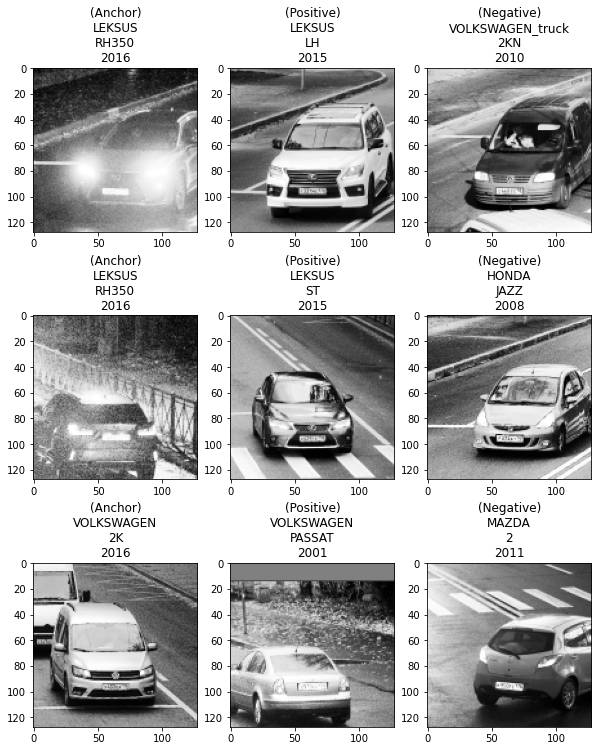

In [6]:
_ = tl_ds_test.tl_ds_test(tl_ds_train, n_rows=3, line_span=1.3)

**Тест модели**

In [7]:
marks_features_len = 128
tl_mark_model = TripletLossModel(marks_features_len)

Визуальный:

<Figure size 432x288 with 0 Axes>

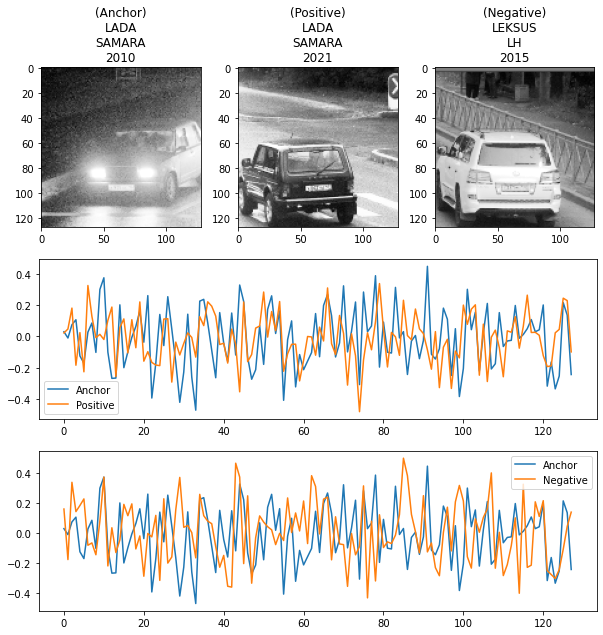

In [8]:
_ = tl_m_test.test_tl_moldel(tl_mark_model, tl_ds_train, 1)

Критерий отношения дисперсий:

In [9]:
vectorizer = Vectorizer()

In [10]:
vectorizer.vectorize(classif_ds_test, tl_mark_model)

  0%|          | 0/167 [00:00<?, ?it/s]

In [11]:
var_crit = CustomVarianceCriteria()

In [12]:
var_crit_bef_learn = var_crit.scope(vectorizer.vects_res, vectorizer.lables_res)
print(f'Критерий отношения дисперсий до обучения: {round(var_crit_bef_learn, 3)}')

Критерий отношения дисперсий до обучения: 66150715.726


**Обучение модели**

In [13]:
criterion = TripletMarginLoss(margin=30)
optimizer = Adam(tl_mark_model.parameters(), lr=0.0001)

tl_mark_model.compile_settings(criterion, optimizer)

C:\Users\ski6a\anaconda3\envs\cv_env\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [27]:
current_time = strftime('%d-%m_%H-%M-%S')
logdir = f'runs2/{current_time}'
# logdir = f'runs2/30-06_22-05-40'
print(f'logdir: {logdir}')
os.makedirs(logdir)
writer = SummaryWriter(log_dir=logdir)

loss_function = TripletMarginLoss(margin=30)
delimeter=20
w_filepaths = ['weights/2. triplet loss model - marks/conv2Dfeatures.pt',
               'weights/2. triplet loss model - marks/fully_connect.pt']

callback = tl_call.TripletLossCallBack(writer, classif_ds_test,
                                       loss_function, delimeter,
                                       w_filepaths)

logdir: runs2/01-07_15-14-26


In [16]:
conv_block_wp = 'weights/1. classify for triplet loss - marks/900 epochs/conv2Dfeatures.pt'
fc_block_wp = 'weights/1. classify for triplet loss - marks/900 epochs/fully_connect.pt'

tl_mark_model.load_conv_block(conv_block_wp)
tl_mark_model.load_warmstart_fc_block(fc_block_wp)

In [14]:
w_filepaths_load = [
    'weights/2. triplet loss model - marks/1. 434 epochs/conv2Dfeatures_last.pt',
    'weights/2. triplet loss model - marks/1. 434 epochs/fully_connect_last.pt'
]

tl_mark_model.split_load(w_filepaths_load)

In [29]:
epochs = 10000
# tl_mark_model.fit(tl_ds_train, epochs, callback=callback)

Визуальный тест модели:

<Figure size 432x288 with 0 Axes>

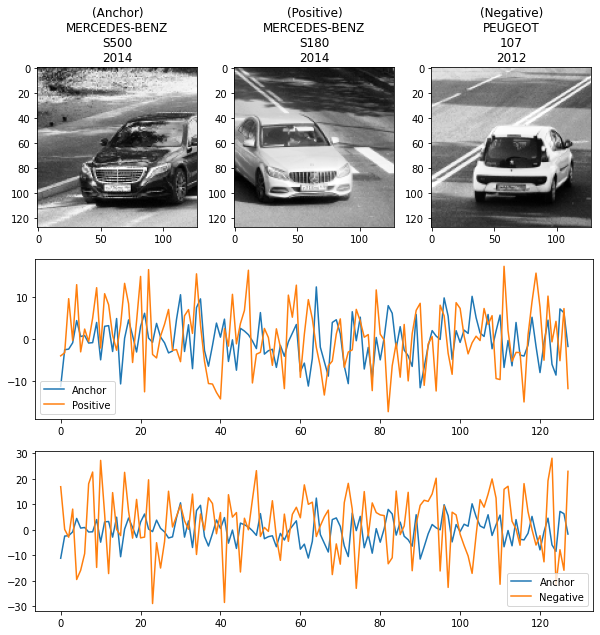

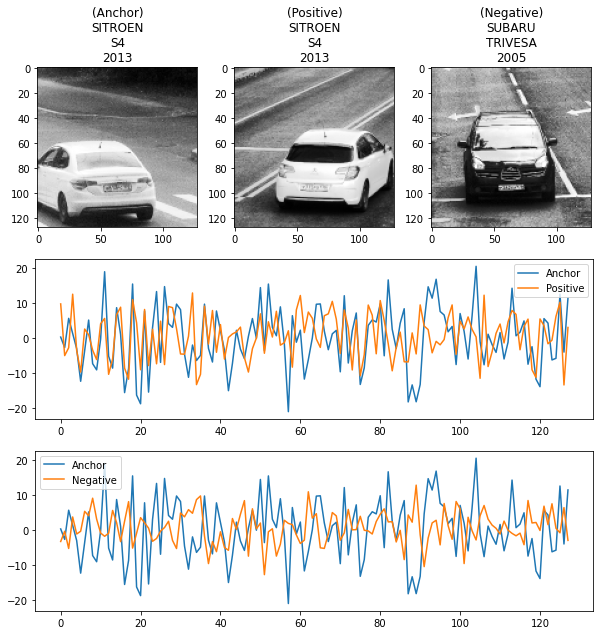

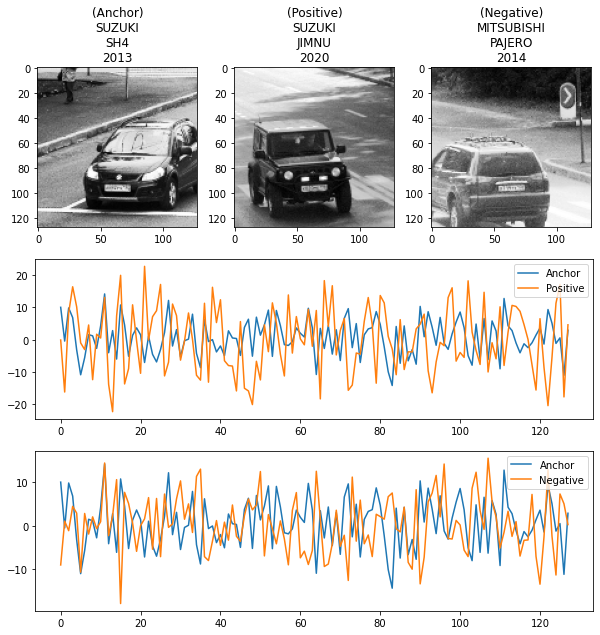

In [39]:
_ = tl_m_test.test_tl_moldel(tl_mark_model, tl_ds_train, 3)

Критерий отношения дисперсий:

In [40]:
vectorizer = Vectorizer()

In [41]:
vectorizer.vectorize(classif_ds_test, tl_mark_model)

  0%|          | 0/167 [00:00<?, ?it/s]

In [42]:
var_crit = CustomVarianceCriteria()

In [43]:
var_crit_aft_learn = var_crit.scope(vectorizer.vects_res, vectorizer.lables_res)
print(f'Критерий отношения дисперсий после обучения: {round(var_crit_aft_learn, 3)}')

Критерий отношения дисперсий после обучения: 0.02
